In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import string
import nltk
from nltk.stem.porter import *
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost  import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import gensim
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
train.shape

(31962, 3)

In [4]:
test.shape

(17197, 2)

In [5]:
train['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [6]:
stemmer = PorterStemmer()

def text_cleaner(input_text):
    # Remove @
    text = re.sub(r'@[\w]*', '', input_text)

    # Remove everything except characters and hashtags
    text = re.sub(r"[^a-zA-Z#]", ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # # Remove hashtags
    # text = re.sub(r'#[\w]*', '', text)
    
    # Convert text to lowercase
    text = text.lower()

    # Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    words = text.split()
    text = " ".join([word for word in words if word not in stopwords])

    # Stemming
    split_tweet = text.split()
    stemmed_tweet = [stemmer.stem(word) for word in split_tweet]
    text = " ".join(stemmed_tweet)

    return text

In [7]:
train['tweet'] = train['tweet'].apply(text_cleaner)
test['tweet'] = test['tweet'].apply(text_cleaner)

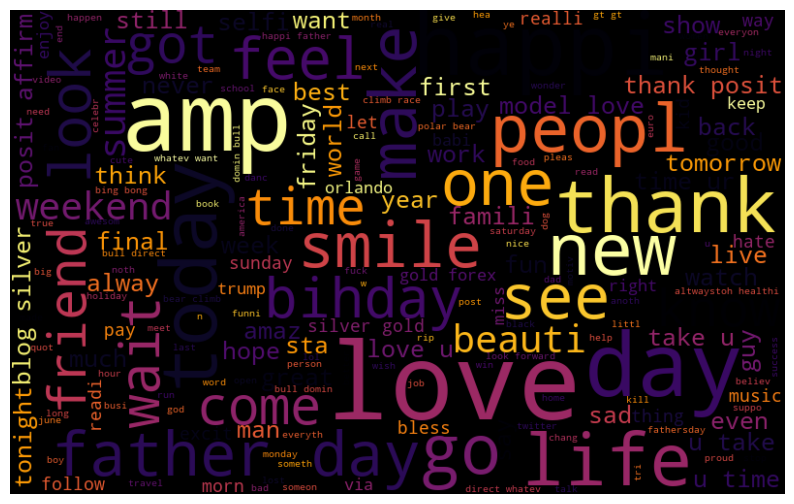

In [8]:
# Tweet words visualisation

vocabulary = ' '.join([x for x in train['tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='inferno').generate(vocabulary)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

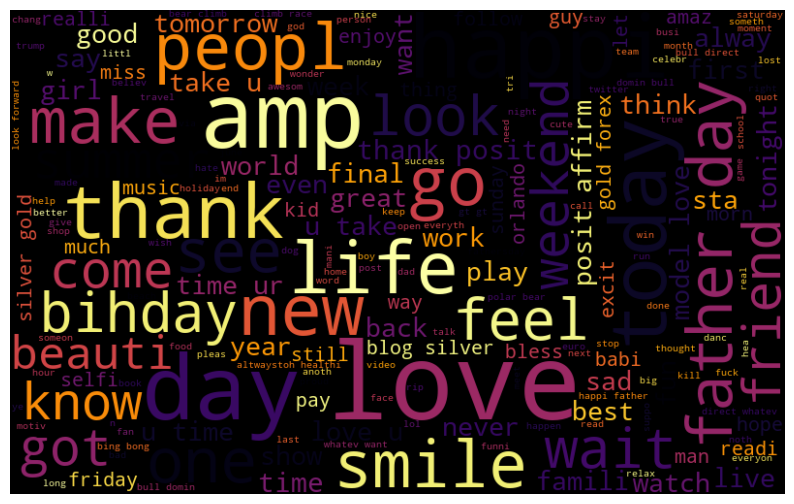

In [9]:
pos_tweet_vocabulary = ' '.join([x for x in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='inferno').generate(pos_tweet_vocabulary)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

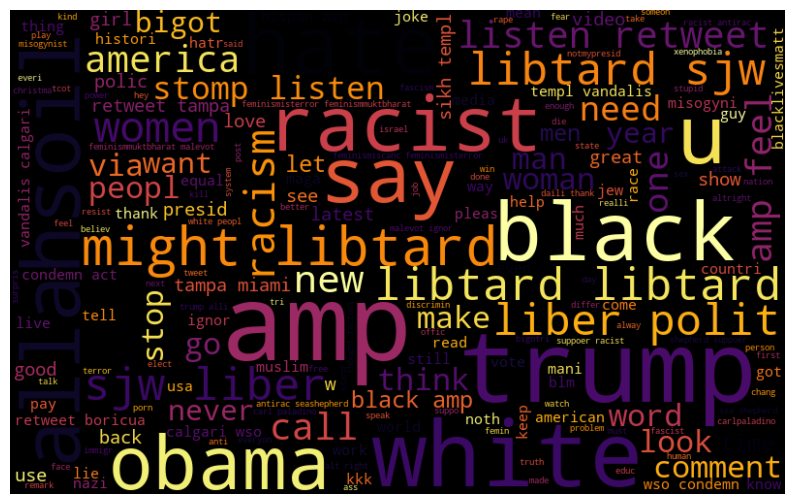

In [10]:
neg_tweet_vocab = ' '.join([x for x in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, colormap='inferno').generate(neg_tweet_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
# Bag of Words

bow_vectorizer = CountVectorizer(max_features=1000)
bow = bow_vectorizer.fit_transform(train['tweet'])
bow.shape

(31962, 1000)

In [12]:
# Tfidf 

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(train['tweet'])
tfidf.shape

(31962, 1000)

In [13]:
# Word2Vec

tokenized_tweet = train['tweet'].apply(lambda x : x.split())

model_w2v = gensim.models.Word2Vec(tokenized_tweet, vector_size=200, window=5, min_count=2, workers=4)
model_w2v.train(tokenized_tweet,total_examples=len(train['tweet']),epochs=20)

(4271553, 4929080)

In [14]:
def word_vector(tokens,size):
    vec = np.zeros(size).reshape((1,size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1,size))
            count += 1
        except:
            continue
    if count != 0:
        vec /= count
    
    return vec

In [15]:
word2vec_arrays = np.zeros((len(tokenized_tweet),200))

for i in range(len(tokenized_tweet)):
    word2vec_arrays[i,:] = word_vector(tokenized_tweet[i],200)

word2vec_df = pd.DataFrame(word2vec_arrays)
word2vec_df.shape

(31962, 200)

In [16]:
word2vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.154877,0.024971,0.155812,0.147746,0.630982,-0.082015,-0.321780,0.616836,0.070153,0.347847,...,0.470190,-0.289732,0.117192,-0.412406,0.226285,0.218242,-0.031028,-0.265644,0.187149,-0.295638
1,-0.036891,0.016848,0.315685,0.424513,0.440757,-0.013971,-0.178111,0.471599,0.096688,0.014499,...,0.005825,-0.288458,0.015339,-0.007433,0.076144,-0.052090,0.200619,0.033368,0.134937,-0.169171
2,-0.303684,0.115336,-0.943621,0.438452,0.144183,0.212664,0.453222,0.400689,-0.361458,0.697759,...,-0.247305,0.787964,-0.004047,0.245052,1.010561,-0.041714,0.300277,-0.438546,-0.557430,-0.296841
3,0.456207,-0.777417,0.474114,0.741412,0.033775,0.531348,0.307592,0.675753,0.052498,-0.479806,...,0.581363,0.194472,0.145752,-0.365147,0.355890,-0.021782,-0.485285,-0.279198,0.470506,-0.296321
4,-0.013918,0.487928,0.118943,0.312227,-0.017748,-0.262470,-0.378471,0.089224,-0.484039,0.196545,...,0.676943,0.225886,0.132185,-0.228237,0.384066,-0.091460,-0.416091,-0.244428,-0.077090,-0.154224


In [20]:
# Implementing Logistic Regression

x_train_bow, x_val_bow, y_train_bow, y_val_bow = train_test_split(bow,train['label'],test_size=0.2,random_state=42)

bow_log_reg = LogisticRegression()
bow_log_reg.fit(x_train_bow, y_train_bow)
bow_log_reg_pred = bow_log_reg.predict_proba(x_val_bow)
bow_log_reg_pred = bow_log_reg_pred[:,1] >= 0.3
f1_bow_log_reg = f1_score(y_val_bow, bow_log_reg_pred)
print("f1 score of bag of words features on logistic regression :",f1_bow_log_reg)
bow_accuracy = bow_log_reg.score(x_val_bow, y_val_bow)
print("accuracy score of bag of words features on logistic regression :",bow_accuracy)


x_train_tfidf, x_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(tfidf,train['label'],test_size=0.2,random_state=42)

tfidf_log_reg = LogisticRegression()
tfidf_log_reg.fit(x_train_tfidf, y_train_tfidf)
tfidf_log_reg_pred = tfidf_log_reg.predict_proba(x_val_tfidf)
tfidf_log_reg_pred = tfidf_log_reg_pred[:,1] >= 0.3
f1_tfidf_log_reg = f1_score(y_val_tfidf, tfidf_log_reg_pred)
print("f1 score of tfidf features on logistic regression :",f1_tfidf_log_reg)
tfidf_accuracy = tfidf_log_reg.score(x_val_tfidf, y_val_tfidf)
print("accuracy score of tfidf features on logistic regression :",tfidf_accuracy)


x_train_word2vec, x_val_word2vec, y_train_word2vec, y_val_word2vec = train_test_split(word2vec_df,train['label'],test_size=0.2,random_state=42)

word2vec_log_reg = LogisticRegression()
word2vec_log_reg.fit(x_train_word2vec, y_train_word2vec)
word2vec_log_reg_pred = word2vec_log_reg.predict_proba(x_val_word2vec)
word2vec_log_reg_pred = word2vec_log_reg_pred[:,1] >= 0.3
f1_word2vec_log_reg = f1_score(y_val_word2vec, word2vec_log_reg_pred)
print("f1 score of word2vec features on logistic regression :",f1_word2vec_log_reg)
word2vec_accuracy = word2vec_log_reg.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on logistic regression :",word2vec_accuracy)

f1 score of bag of words features on logistic regression : 0.5703971119133574
accuracy score of bag of words features on logistic regression : 0.9460347254809949
f1 score of tfidf features on logistic regression : 0.5839598997493733
accuracy score of tfidf features on logistic regression : 0.9466604098232442
f1 score of word2vec features on logistic regression : 0.5758928571428571
accuracy score of word2vec features on logistic regression : 0.9430627248553105


c:\Users\pandy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Implementing SVM 

bow_svc = svm.SVC(kernel="linear" , C=1 , probability=True).fit(x_train_bow,y_train_bow)

bow_svc_pred = bow_svc.predict_proba(x_val_bow)
bow_svc_pred = bow_svc_pred[:,1] >= 0.3
f1_bow_svc = f1_score(y_val_bow, bow_svc_pred)
print("f1 score of bag of words features on SVM :",f1_bow_svc)
bow_svc_accuracy = bow_svc.score(x_val_bow, y_val_bow)
print("accuracy score of bag of words features on SVM :",bow_svc_accuracy)


tfidf_svc = svm.SVC(kernel="linear" , C=1 , probability=True).fit(x_train_tfidf,y_train_tfidf)

tfidf_svc_pred = tfidf_svc.predict_proba(x_val_tfidf)
tfidf_svc_pred = tfidf_svc_pred[:,1] >= 0.3
f1_tfidf_svc = f1_score(y_val_tfidf, tfidf_svc_pred)
print("f1 score of tfidf features on SVM :",f1_tfidf_svc)
tfidf_svc_accuracy = tfidf_svc.score(x_val_tfidf, y_val_tfidf)
print("accuracy score of tfidf features on SVM :",tfidf_svc_accuracy)


word2vec_svc = svm.SVC(kernel="linear" , C=1 , probability=True).fit(x_train_word2vec,y_train_word2vec)

word2vec_svc_pred = word2vec_svc.predict_proba(x_val_word2vec)
word2vec_svc_pred = word2vec_svc_pred[:,1] >= 0.3
f1_word2vec_svc = f1_score(y_val_word2vec, word2vec_svc_pred)
print("f1 score of word2vec features on SVM :",f1_word2vec_svc)
word2vec_svc_accuracy = word2vec_svc.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on SVM :",word2vec_svc_accuracy)

f1 score of bag of words features on SVM : 0.5540540540540542
accuracy score of bag of words features on SVM : 0.9474425152510558
f1 score of tfidf features on SVM : 0.538562091503268
accuracy score of tfidf features on SVM : 0.9469732519943689
f1 score of word2vec features on SVM : 0.5567502986857826
accuracy score of word2vec features on SVM : 0.9429063037697482


In [ ]:
# Implementing SVM 

bow_svc = svm.SVC(kernel="poly" , C=1 , probability=True).fit(x_train_bow,y_train_bow)

bow_svc_pred = bow_svc.predict_proba(x_val_bow)
bow_svc_pred = bow_svc_pred[:,1] >= 0.3
f1_bow_svc = f1_score(y_val_bow, bow_svc_pred)
print("f1 score of bag of words features on SVM :",f1_bow_svc)
bow_svc_accuracy = bow_svc.score(x_val_bow, y_val_bow)
print("accuracy score of bag of words features on SVM :",bow_svc_accuracy)


tfidf_svc = svm.SVC(kernel="poly" , C=1 , probability=True).fit(x_train_tfidf,y_train_tfidf)

tfidf_svc_pred = tfidf_svc.predict_proba(x_val_tfidf)
tfidf_svc_pred = tfidf_svc_pred[:,1] >= 0.3
f1_tfidf_svc = f1_score(y_val_tfidf, tfidf_svc_pred)
print("f1 score of tfidf features on SVM :",f1_tfidf_svc)
tfidf_svc_accuracy = tfidf_svc.score(x_val_tfidf, y_val_tfidf)
print("accuracy score of tfidf features on SVM :",tfidf_svc_accuracy)


word2vec_svc = svm.SVC(kernel="poly" , C=1 , probability=True).fit(x_train_word2vec,y_train_word2vec)

word2vec_svc_pred = word2vec_svc.predict_proba(x_val_word2vec)
word2vec_svc_pred = word2vec_svc_pred[:,1] >= 0.3
f1_word2vec_svc = f1_score(y_val_word2vec, word2vec_svc_pred)
print("f1 score of word2vec features on SVM :",f1_word2vec_svc)
word2vec_svc_accuracy = word2vec_svc.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on SVM :",word2vec_svc_accuracy)

f1 score of bag of words features on SVM : 0.5185185185185185
accuracy score of bag of words features on SVM : 0.9432191459408729
f1 score of tfidf features on SVM : 0.6046511627906977
accuracy score of tfidf features on SVM : 0.9519787267323635
f1 score of word2vec features on SVM : 0.5566166439290586
accuracy score of word2vec features on SVM : 0.9411856718285625


In [ ]:
# Implementing SVM 

bow_svc = svm.SVC(kernel="rbf" , C=1 , probability=True).fit(x_train_bow,y_train_bow)

bow_svc_pred = bow_svc.predict_proba(x_val_bow)
bow_svc_pred = bow_svc_pred[:,1] >= 0.3
f1_bow_svc = f1_score(y_val_bow, bow_svc_pred)
print("f1 score of bag of words features on SVM :",f1_bow_svc)
bow_svc_accuracy = bow_svc.score(x_val_bow, y_val_bow)
print("accuracy score of bag of words features on SVM :",bow_svc_accuracy)


tfidf_svc = svm.SVC(kernel="rbf" , C=1 , probability=True).fit(x_train_tfidf,y_train_tfidf)

tfidf_svc_pred = tfidf_svc.predict_proba(x_val_tfidf)
tfidf_svc_pred = tfidf_svc_pred[:,1] >= 0.3
f1_tfidf_svc = f1_score(y_val_tfidf, tfidf_svc_pred)
print("f1 score of tfidf features on SVM :",f1_tfidf_svc)
tfidf_svc_accuracy = tfidf_svc.score(x_val_tfidf, y_val_tfidf)
print("accuracy score of tfidf features on SVM :",tfidf_svc_accuracy)


word2vec_svc = svm.SVC(kernel="rbf" , C=1 , probability=True).fit(x_train_word2vec,y_train_word2vec)

word2vec_svc_pred = word2vec_svc.predict_proba(x_val_word2vec)
word2vec_svc_pred = word2vec_svc_pred[:,1] >= 0.3
f1_word2vec_svc = f1_score(y_val_word2vec, word2vec_svc_pred)
print("f1 score of word2vec features on SVM :",f1_word2vec_svc)
word2vec_svc_accuracy = word2vec_svc.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on SVM :",word2vec_svc_accuracy)

f1 score of bag of words features on SVM : 0.5882352941176471
accuracy score of bag of words features on SVM : 0.9485374628499922
f1 score of tfidf features on SVM : 0.6207759699624531
accuracy score of tfidf features on SVM : 0.9499452526200531
f1 score of word2vec features on SVM : 0.5954198473282444
accuracy score of word2vec features on SVM : 0.9458783043954325


so the best svm kernels for the respective features are :

bag of words : rbf
tfidf : rbf
word2vec : rbf

In [ ]:
# Implementing Random Forest Classifier

bow_rf = RandomForestClassifier(n_estimators=400, random_state=42).fit(x_train_bow,y_train_bow)

bow_rf_pred = bow_rf.predict(x_val_bow)
f1_bow_rf = f1_score(y_val_bow, bow_rf_pred)
print("f1 score of bag of words features on Random Forest :",f1_bow_rf)
bow_rf_accuracy = bow_rf.score(x_val_bow, y_val_bow)
print("accuracy score of bag of words features on Random Forest :",bow_rf_accuracy)


tfidf_rf = RandomForestClassifier(n_estimators=400, random_state=42).fit(x_train_tfidf,y_train_tfidf)

tfidf_rf_pred = tfidf_rf.predict(x_val_tfidf)
f1_tfidf_rf = f1_score(y_val_tfidf, tfidf_rf_pred)
print("f1 score of tfidf features on Random Forest :",f1_tfidf_rf)
tfidf_rf_accuracy = tfidf_rf.score(x_val_tfidf, y_val_tfidf)
print("accuracy score of tfidf features on Random Forest :",tfidf_rf_accuracy) 


word2vec_rf = RandomForestClassifier(n_estimators=400, random_state=42).fit(x_train_word2vec,y_train_word2vec)

word2vec_rf_pred = word2vec_rf.predict(x_val_word2vec)
f1_word2vec_rf = f1_score(y_val_word2vec, word2vec_rf_pred)
print("f1 score of word2vec features on Random Forest :",f1_word2vec_rf)
word2vec_rf_accuracy = word2vec_rf.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on Random Forest :",word2vec_rf_accuracy)

f1 score of bag of words features on Random Forest : 0.58165548098434
accuracy score of bag of words features on Random Forest : 0.9414985139996872
f1 score of tfidf features on Random Forest : 0.6026666666666666
accuracy score of tfidf features on Random Forest : 0.9533865165024246
f1 score of word2vec features on Random Forest : 0.5951359084406295
accuracy score of word2vec features on Random Forest : 0.9557328327858595


In [21]:
# Implementing XGBoost

bow_xgb = XGBClassifier(max_depth=6, n_estimators=1000, random_state=42).fit(x_train_bow,y_train_bow)

bow_xgb_pred = bow_xgb.predict(x_val_bow)
f1_bow_xgb = f1_score(y_val_bow, bow_xgb_pred)
print("f1 score of bag of words features on XGBoost :",f1_bow_xgb)
bow_xgb_accuracy = bow_xgb.score(x_val_bow, y_val_bow)
print("accuracy score of bag of words features on XGBoost :",bow_xgb_accuracy)


tfidf_xgb = XGBClassifier(max_depth=6, n_estimators=1000, random_state=42).fit(x_train_tfidf,y_train_tfidf)

tfidf_xgb_pred = tfidf_xgb.predict(x_val_tfidf)
f1_tfidf_xgb = f1_score(y_val_tfidf, tfidf_xgb_pred)
print("f1 score of tfidf features on XGBoost :",f1_tfidf_xgb)
tfidf_xgb_accuracy = tfidf_xgb.score(x_val_tfidf, y_val_tfidf)
print("accuracy score of tfidf features on XGBoost :",tfidf_xgb_accuracy)


word2vec_xgb = XGBClassifier(max_depth=6, n_estimators=1000, random_state=42).fit(x_train_word2vec,y_train_word2vec)

word2vec_xgb_pred = word2vec_xgb.predict(x_val_word2vec)
f1_word2vec_xgb = f1_score(y_val_word2vec, word2vec_xgb_pred)
print("f1 score of word2vec features on XGBoost :",f1_word2vec_xgb)
word2vec_xgb_accuracy = word2vec_xgb.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on XGBoost :",word2vec_xgb_accuracy)

f1 score of bag of words features on XGBoost : 0.5691275167785235
accuracy score of bag of words features on XGBoost : 0.9497888315344909
f1 score of tfidf features on XGBoost : 0.5984251968503937
accuracy score of tfidf features on XGBoost : 0.9521351478179259
f1 score of word2vec features on XGBoost : 0.655819774718398
accuracy score of word2vec features on XGBoost : 0.9569842014703582


In [51]:
# fine tuning xgboost on word2vec as it has given best f1 score till now

word2vec_xgb_tuned = XGBClassifier(max_depth=8, n_estimators=1000, random_state=42, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8).fit(x_train_word2vec,y_train_word2vec)

word2vec_xgb_tuned_pred = word2vec_xgb_tuned.predict_proba(x_val_word2vec)
word2vec_xgb_tuned_pred = (word2vec_xgb_tuned_pred[:,1] >= 0.1).astype(int)
f1_word2vec_xgb_tuned = f1_score(y_val_word2vec, word2vec_xgb_tuned_pred)
print("f1 score of word2vec features on XGBoost (tuned) :",f1_word2vec_xgb_tuned)
word2vec_xgb_tuned_accuracy = word2vec_xgb_tuned.score(x_val_word2vec, y_val_word2vec)
print("accuracy score of word2vec features on XGBoost (tuned) :",word2vec_xgb_tuned_accuracy)

f1 score of word2vec features on XGBoost (tuned) : 0.6881959910913141
accuracy score of word2vec features on XGBoost (tuned) : 0.9579227279837322


In [53]:
# extracting word2vec features from test data

tokenized_test_tweet = test['tweet'].apply(lambda x : x.split())
test_word2vec_arrays = np.zeros((len(tokenized_test_tweet),200))

for i in range(len(tokenized_test_tweet)):
    test_word2vec_arrays[i,:] = word_vector(tokenized_test_tweet[i],200)

test_word2vec_df = pd.DataFrame(test_word2vec_arrays)

# predictions on test data

test_word2vec_xgb_tuned_pred = word2vec_xgb_tuned.predict_proba(test_word2vec_df)
test_word2vec_xgb_tuned_pred = (test_word2vec_xgb_tuned_pred[:,1] >= 0.1).astype(int)
test['label'] = test_word2vec_xgb_tuned_pred
submission = test[["id","label"]]
submission.to_csv('submission.csv', index=False)

score for this submission is : 0.677 (f1-score)
